In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# CE loss 学习率为1e-1
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

CE_Acc_1e1 = np.array([tensor.item() for tensor in list])
print(CE_Acc_1e1)

Epoch: 1/30 Train Loss: 0.0152 Acc: 0.2719
Begin test......
Test Loss: 0.0149 Acc: 0.3082
Epoch: 2/30 Train Loss: 0.0144 Acc: 0.3090
Begin test......
Test Loss: 0.0139 Acc: 0.3328
Epoch: 3/30 Train Loss: 0.0142 Acc: 0.3185
Begin test......
Test Loss: 0.0136 Acc: 0.3455
Epoch: 4/30 Train Loss: 0.0139 Acc: 0.3305
Begin test......
Test Loss: 0.0134 Acc: 0.3623
Epoch: 5/30 Train Loss: 0.0141 Acc: 0.3279
Begin test......
Test Loss: 0.0134 Acc: 0.3440
Epoch: 6/30 Train Loss: 0.0132 Acc: 0.3709
Begin test......
Test Loss: 0.0125 Acc: 0.4076
Epoch: 7/30 Train Loss: 0.0129 Acc: 0.3864
Begin test......
Test Loss: 0.0124 Acc: 0.4248
Epoch: 8/30 Train Loss: 0.0128 Acc: 0.3929
Begin test......
Test Loss: 0.0132 Acc: 0.3968
Epoch: 9/30 Train Loss: 0.0127 Acc: 0.4041
Begin test......
Test Loss: 0.0119 Acc: 0.4418
Epoch: 10/30 Train Loss: 0.0127 Acc: 0.4009
Begin test......
Test Loss: 0.0123 Acc: 0.4332
Epoch: 11/30 Train Loss: 0.0121 Acc: 0.4277
Begin test......
Test Loss: 0.0114 Acc: 0.4701
Epoch: 1

In [3]:
# CE loss 学习率为1e-2
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

CE_Acc_1e2 = np.array([tensor.item() for tensor in list])
print(CE_Acc_1e2)

Epoch: 1/30 Train Loss: 0.0149 Acc: 0.3012
Begin test......
Test Loss: 0.0125 Acc: 0.4182
Epoch: 2/30 Train Loss: 0.0127 Acc: 0.4091
Begin test......
Test Loss: 0.0117 Acc: 0.4670
Epoch: 3/30 Train Loss: 0.0120 Acc: 0.4434
Begin test......
Test Loss: 0.0111 Acc: 0.4878
Epoch: 4/30 Train Loss: 0.0116 Acc: 0.4666
Begin test......
Test Loss: 0.0105 Acc: 0.5277
Epoch: 5/30 Train Loss: 0.0112 Acc: 0.4830
Begin test......
Test Loss: 0.0103 Acc: 0.5338
Epoch: 6/30 Train Loss: 0.0108 Acc: 0.5070
Begin test......
Test Loss: 0.0099 Acc: 0.5522
Epoch: 7/30 Train Loss: 0.0107 Acc: 0.5123
Begin test......
Test Loss: 0.0098 Acc: 0.5596
Epoch: 8/30 Train Loss: 0.0105 Acc: 0.5193
Begin test......
Test Loss: 0.0098 Acc: 0.5570
Epoch: 9/30 Train Loss: 0.0104 Acc: 0.5263
Begin test......
Test Loss: 0.0098 Acc: 0.5615
Epoch: 10/30 Train Loss: 0.0104 Acc: 0.5244
Begin test......
Test Loss: 0.0097 Acc: 0.5628
Epoch: 11/30 Train Loss: 0.0102 Acc: 0.5364
Begin test......
Test Loss: 0.0094 Acc: 0.5803
Epoch: 1

In [4]:
# CE loss 学习率为1e-3
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

criterion = nn.CrossEntropyLoss()

def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target) 
    return output, loss

def test_batch(model, image, target):
    output = model(image)   
    loss = criterion(output, target)
    return output, loss

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()
    running_cls_loss = 0.0
    running_cls_corrects = 0
    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    scheduler.step()
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        list.append(val_acc)
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        if (epoch +1) == NUM_EPOCHS:  
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

CE_Acc_1e3 = np.array([tensor.item() for tensor in list])
print(CE_Acc_1e3)

Epoch: 1/30 Train Loss: 0.0179 Acc: 0.1283
Begin test......
Test Loss: 0.0176 Acc: 0.1911
Epoch: 2/30 Train Loss: 0.0170 Acc: 0.2041
Begin test......
Test Loss: 0.0165 Acc: 0.2616
Epoch: 3/30 Train Loss: 0.0164 Acc: 0.2401
Begin test......
Test Loss: 0.0159 Acc: 0.2856
Epoch: 4/30 Train Loss: 0.0156 Acc: 0.2746
Begin test......
Test Loss: 0.0149 Acc: 0.3108
Epoch: 5/30 Train Loss: 0.0148 Acc: 0.3144
Begin test......
Test Loss: 0.0139 Acc: 0.3697
Epoch: 6/30 Train Loss: 0.0142 Acc: 0.3406
Begin test......
Test Loss: 0.0136 Acc: 0.3872
Epoch: 7/30 Train Loss: 0.0140 Acc: 0.3536
Begin test......
Test Loss: 0.0134 Acc: 0.3896
Epoch: 8/30 Train Loss: 0.0138 Acc: 0.3606
Begin test......
Test Loss: 0.0132 Acc: 0.4032
Epoch: 9/30 Train Loss: 0.0137 Acc: 0.3715
Begin test......
Test Loss: 0.0131 Acc: 0.4062
Epoch: 10/30 Train Loss: 0.0136 Acc: 0.3760
Begin test......
Test Loss: 0.0129 Acc: 0.4140
Epoch: 11/30 Train Loss: 0.0134 Acc: 0.3834
Begin test......
Test Loss: 0.0128 Acc: 0.4199
Epoch: 1

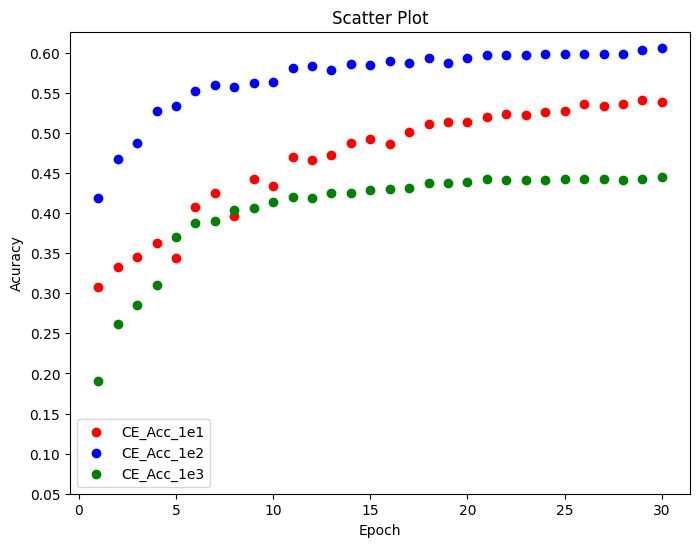

In [5]:
plt.figure(figsize=(8, 6))

x = torch.arange(1, 31)

plt.scatter(x, CE_Acc_1e1, color='red', label='CE_Acc_1e1')
plt.scatter(x, CE_Acc_1e2, color='blue', label='CE_Acc_1e2')
plt.scatter(x, CE_Acc_1e3, color='green', label='CE_Acc_1e3')


plt.title("Scatter Plot")
plt.xlabel("Epoch")
plt.ylabel("Acuracy")

plt.yticks(np.arange(0.05, 0.65, 0.05))

plt.legend()

plt.show()